In this notebook, we generate the access logs with operation attributes.

In [1]:
### Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit

## Auxiliar functions

In [2]:
###
class AccessLog:
    """ All operation in AccessLog (AL) """
    def __init__(self, df_users, df_rscs, operators) -> None:
        """ Initialize AL attributes """
        self.df_users = df_users
        self.df_rscs = df_rscs
        self.user_attrs = df_users.columns
        self.rsrc_attrs = df_rscs.columns
        self.universal_access_log = []
        self.operators = operators # a list
    
    def compute_universal_al(self) -> None:
        """ Compute the universal Access Log (UAL). |UAL| = |U| x |R|"""
        access_log = []
        for user in self.df_users.values:
            for res in self.df_rscs.values:
                for op in self.operators:   
                    access_log.append(list(user) + list(res) + [op])
        
        access_log = pd.DataFrame(access_log)        
        access_log.columns = list(self.df_users.columns) + list(self.df_rscs.columns) + ["op"]
        self.universal_access_log = access_log

    def policy_evaluation(self, policy) -> None:
        """ Compare each access record with a policy set."""
        false_negs = [] # False negatives
        true_pos = [] # True positives
        len_policy = len(policy)

        for acc_req in self.universal_access_log.iloc:
            denies_count = 0
            for rule in policy:
                res = True
                for item_rule in rule:
                    if item_rule[0] == 0:
                        if acc_req[item_rule[1]] != item_rule[2]:
                            res = False
                            break
                    if item_rule[0] == 1: # => attr1.val = attr2.val
                        if acc_req[item_rule[1]] != acc_req[item_rule[2]]:
                            res = False
                            break

                if res == False:
                    denies_count += 1
            if denies_count == len_policy:
                false_negs.append(acc_req)
            else:
                true_pos.append(acc_req)
        
        false_negs = pd.DataFrame(false_negs)
        true_pos = pd.DataFrame(true_pos)

        print("FN;", len(false_negs), "\t\tTP:", len(true_pos))

        # Add "ACTION" column
        false_negs["ACTION"] = 0
        true_pos["ACTION"] = 1

        # Access log with "ACTION" column
        self.universal_access_log = pd.concat([true_pos,false_negs])

    def get_sparse_al(self, fraction, random_state=None, previous_al=None):        
        """ Compute the sparse access log (SAL) version. """
        acc_log = self.universal_access_log
        if isinstance(previous_al, pd.DataFrame):
            acc_log = previous_al
        sparse_positive_al = None   
        pos_access_req = acc_log[acc_log["ACTION"]==1]
        if random_state != None:
            sparse_positive_al = pos_access_req.sample(frac=fraction,
                                                       random_state=random_state)
        else:
            sparse_positive_al = pos_access_req.sample(frac=fraction)

        return pd.concat([sparse_positive_al, acc_log[acc_log["ACTION"]==0]])

    def get_noisy_al(self, fraction, random_state=None, previous_al=None):
        """ Compute the noisy access log (NAL) version. """
        acc_log = self.universal_access_log
        if isinstance(previous_al, pd.DataFrame):
            acc_log = previous_al

        noysi_al = None
        if random_state != None:
            noisy_separation = StratifiedShuffleSplit(n_splits = 1,
                                                      train_size = fraction,
                                                      random_state = random_state)
        else:
            noisy_separation = StratifiedShuffleSplit(n_splits = 1,
                                                      train_size = fraction)
        
        noisy_acc_log_selection = noisy_separation.split(acc_log, acc_log.ACTION)
                        
        noisy_acc_req = None
        normal_acc_req = None
        for noisy_idx, normal_idx, in noisy_acc_log_selection:
            noisy_acc_req = acc_log.iloc[noisy_idx]
            normal_acc_req = acc_log.iloc[normal_idx]

        # Change the resolution in the noisy_selection dataset
        noisy_acc_req["ACTION"] = np.where(noisy_acc_req["ACTION"] == 0, 1, 0)

        noysi_al = pd.concat([noisy_acc_req, normal_acc_req])

        return noysi_al

    def get_balanced_al(self, positive_frac, random_state = None, previous_al = None):
        acc_log = self.universal_access_log
        
        if isinstance(previous_al, pd.DataFrame):
            acc_log = previous_al        

        # Compute the original balanced
        pos_acc_log = acc_log[acc_log["ACTION"]==1]
        neg_acc_log = acc_log[acc_log["ACTION"]==0]

        len_al = len(acc_log)
        len_pos_ar = len(pos_acc_log)

        limit_positive_frac = ( len_pos_ar * 100 ) / len_al

        if positive_frac < limit_positive_frac and positive_frac > 1:
            print("Is not possible")
            return
        
        len_neg_ar = int(( (1-positive_frac) * 100 * len_pos_ar ) / (positive_frac*100))        

        neg_acc_req = []
        if random_state != None:
            neg_acc_req = neg_acc_log.sample(n=len_neg_ar,
                                             random_state=random_state)
        else:
            neg_acc_req = neg_acc_log.sample(n=len_neg_ar)

        return pd.concat([pos_acc_log, neg_acc_req])

        


## Healthcare policy

In [3]:
# 0 = attribute = value
# 1 = attribute = attribute => attribute.value = attribute.value

policy_hc = [
    [
        [0, "position", "nurse"],
        [0, "type", "HR"],
        [1, "uward", "rward"],
        [0, "op", "addItem"]
    ],
    [
        [0, "type", "HR"],
        [1, "tratingTeam", "teams"],    
        [0, "op", "addItem"]
    ],
    [
        [0, "type", "HR"],
        [1, "uname", "patient"],
        [0, "op", "addNote"]
    ],
    [
        [0, "type", "HR"],
        [1, "patient", "agentfor"]
    ],

    [
        [0, "type", "item"],
        [1, "uname", "author"],
        [0, "op", "addNote"]
    ],
    [
        [0, "position", "nurse"],
        [0, "type", "item"],
        [0, "topics", "nursing"],
        [1, "uward", "rward"],
        [0, "op", "read"]
    ],
    [
        [0, "type", "item"],
        [1, "topics", "specialties"],
        [1, "tratingTeam", "teams"],
        [0, "op", "read"]
    ],
    [
        [0, "type", "item"],
        [0, "topics", "note"],
        [1, "uname", "patient"],
        [0, "op", "read"]
    ],
    [
        [0, "type", "item"],
        [0, "topics", "note"],
        [1, "patient", "agentfor"],
        [0, "op", "read"]
    ]
]

In [4]:
### Policy Summary

counter_len = 0
for rule in policy_hc:
    counter_len += len(rule)
print("|R|", len(policy_hc))
print("avg(R)", counter_len/len(policy_hc))
print("WSC", counter_len)

|R| 9
avg(R) 3.5555555555555554
WSC 32


In [5]:
### Load users and resources

# Load users
filepath = "../data/HC/0-HC-users.csv"
df_users = pd.read_csv(filepath)
#df_users = df_users[df_users.columns[1:]] # remove the rname column
df_users = df_users.drop_duplicates() # Remove deplicated users
print("###*** DF - USERS ***###")
print(df_users.info())

# Load resources
filepath = "../data/HC/0-HC-res.csv"
df_res = pd.read_csv(filepath)
df_res = df_res[df_res.columns[1:]] # Remove the ID
df_res = df_res.drop_duplicates() # Remove deplicated resources
print("###*** DF - RESOURCES ***###")
print(df_res.info())

operators = ["addItem", "addNote", "read"]

###*** DF - USERS ***###
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 30
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uname        31 non-null     object
 1   position     31 non-null     object
 2   uward        31 non-null     object
 3   specialties  31 non-null     object
 4   teams        31 non-null     object
 5   agentfor     31 non-null     object
dtypes: object(6)
memory usage: 1.7+ KB
None
###*** DF - RESOURCES ***###
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 30
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   type         31 non-null     object
 1   author       31 non-null     object
 2   patient      31 non-null     object
 3   topics       31 non-null     object
 4   tratingTeam  31 non-null     object
 5   rward        31 non-null     object
dtypes: object(6)
memory usage: 1.7+ KB
N

In [6]:
### Combination of all possible resourcs types.

uniques = [df_res[i].unique().tolist() for i in df_res.columns]
df_res = pd.DataFrame(product(*uniques), columns = df_res.columns)
df_res["rname"] = df_res.index
df_res

,type,author,patient,topics,tratingTeam,rward,rname
0,item,oncNurse1,oncPat1,oncology,oncTeam1,oncward,0
1,item,oncNurse1,oncPat1,oncology,oncTeam1,carward,1
2,item,oncNurse1,oncPat1,oncology,oncTeam2,oncward,2
3,item,oncNurse1,oncPat1,oncology,oncTeam2,carward,3
4,item,oncNurse1,oncPat1,oncology,carTeam1,oncward,4
...,...,...,...,...,...,...,...
4955,HR,carAgent1,carPat1,cardiology,oncTeam2,carward,4955
4956,HR,carAgent1,carPat1,cardiology,carTeam1,oncward,4956
4957,HR,carAgent1,carPat1,cardiology,carTeam1,carward,4957
4958,HR,carAgent1,carPat1,cardiology,carTeam2,oncward,4958


In [7]:

hc_acc_log = AccessLog(df_users=df_users, df_rscs=df_res, operators=operators)
hc_acc_log.compute_universal_al()
hc_acc_log.policy_evaluation(policy_hc)
#hc_sparse_al = hc_acc_log.get_sparse_al(0.5)

FN; 431520 		TP: 29760


In [8]:
hc_acc_log.universal_access_log.to_csv("../data/HC-universal.csv")

## Proejct Managment

In [9]:
policy_pm = [
    [
        [0, "adminroles", "manager"],
        [0, "type", "budget"],
        [1, "department", "departmentu"],
        [0, "op", "read"]
    ],
    [
        [0, "adminroles", "manager"],
        [0, "type", "budget"],
        [1, "department", "departmentu"],
        [0, "op", "approve"]
    ],
    [
        [0, "type", "schedule"],
        [1, "projectsled", "project"],
        [0, "op", "read"]
    ],
    [
        [0, "type", "schedule"],
        [1, "projectsled", "project"],
        [0, "op", "write"]
    ],
    [
        [0, "type", "budget"],
        [1, "projectsled", "project"],
        [0, "op", "read"]
    ],
    [
        [0, "type", "budget"],
        [1, "projectsled", "project"],
        [0, "op", "write"]
    ],
    [
        [0, "type", "schedule"],
        [0, "projects", "project"],
        [0, "op", "read"]
    ],
    [
        [0, "type", "task"],
        [0, "task", "rname"],
        [0, "op", "setStatus"]
    ],
    [
        [0, "type", "task"],
        [0, "proprietary", "0"],
        [1, "project", "projects"],
        [1, "expertise", "expertiseu"],
        [0, "op", "read"]
    ],
    [
        [0, "type", "task"],
        [0, "proprietary", "0"],
        [1, "project", "projects"],
        [1, "expertise", "expertiseu"],
        [0, "op", "request"]
    ],
    [
        [0, "isemployee","0"],
        [0, "type", "task"],
        [1, "project", "projects"],
        [1, "expertise", "expertiseu"],
        [0, "op", "read"]
    ],
    [
        [0, "isemployee","0"],
        [0, "type", "task"],
        [1, "project", "projects"],
        [1, "expertise", "expertiseu"],
        [0, "op", "request"]
    ],
    [
        [0, "adminroles", "auditor"],
        [0, "type", "budget"],
        [1, "project", "projects"],
        [0, "op", "read"]
    ],
    [
        [0, "adminroles", "accountant"],
        [0, "type", "budget"],
        [1, "project", "projects"],
        [0, "op", "read"]
    ],
    [
        [0, "adminroles", "accountant"],
        [0, "type", "budget"],
        [1, "project", "projects"],
        [0, "op", "write"]
    ],
    [
        [0, "adminroles", "accountant"],
        [0, "type", "task"],
        [1, "project", "projects"],
        [0, "op", "setCost"]
    ],
    [
        [0, "adminroles", "planner"],
        [0, "type", "schedule"],
        [1, "project", "projects"],
        [0, "op", "write"]
    ],
    [
        [0, "adminroles", "planner"],
        [0, "type", "task"],
        [1, "project", "projects"],
        [0, "op", "setSchedule"]
    ]
]

In [10]:
### Policy Summary

counter_len = 0
for rule in policy_hc:
    counter_len += len(rule)
print("|R|", len(policy_hc))
print("avg(R)", counter_len/len(policy_hc))
print("WSC", counter_len)

|R| 9
avg(R) 3.5555555555555554
WSC 32


In [18]:
# Load user and resource data
filepath = "../data/PM/0-PM-users.csv"
df_users = pd.read_csv(filepath) # Users
df_users = df_users[df_users.columns[1:]] # remove the rname column
df_users = df_users.drop_duplicates() # Remove deplicated users

filepath = "../data/PM/0-PM-res.csv"
df_res = pd.read_csv(filepath)  # Resources
#df_res = df_res[df_res.columns[1:]]
df_res = df_res.drop_duplicates() # Remove deplicated users

operators = ["read", "setSchedule", "write", "setCost", "request", "setStatus", "approve"]

print(df_users.info(), df_res.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 0 to 77
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   adminroles   78 non-null     object
 1   projects     78 non-null     object
 2   departmentu  78 non-null     object
 3   projectsled  78 non-null     object
 4   expertiseu   78 non-null     object
 5   isemployee   78 non-null     object
 6   task         78 non-null     object
dtypes: object(7)
memory usage: 4.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rname        40 non-null     object
 1   type         40 non-null     object
 2   project      40 non-null     object
 3   department   40 non-null     object
 4   expertise    40 non-null     object
 5   proprietary  40 non-null     object
dtypes: object(6)
memory usage: 2.2+ KB
None None


In [19]:
df_users_sample = df_users.iloc[46:]
df_users_sample = df_users_sample[["projects", "expertiseu", "isemployee", "task"]]

uniques = [df_users_sample[i].unique().tolist() for i in df_users_sample.columns]
df_users_sample = pd.DataFrame(product(*uniques), columns = df_users_sample.columns)
#df_users_sample["uname"] = df_users_sample.index
df_users_sample

,projects,expertiseu,isemployee,task
0,proj11,design,1,proj11task1a
1,proj11,design,1,proj11task2a
2,proj11,design,1,proj11task1
3,proj11,design,1,proj11task2
4,proj11,design,1,proj11task1propa
...,...,...,...,...
507,proj22,coding,0,proj22task2
508,proj22,coding,0,proj22task1propa
509,proj22,coding,0,proj22task2propa
510,proj22,coding,0,proj22task1prop


In [20]:
df_users_test = df_users.drop(range(46, len(df_users)))
df_users_test = pd.concat([df_users_test, df_users_sample])
df_users_test["uname"] = df_users_test.index
df_users_test

,adminroles,projects,departmentu,projectsled,expertiseu,isemployee,task,uname
0,accountant,proj11,none,none,none,none,none,0
1,accountant,proj21,none,none,none,none,none,1
2,accountant,proj12,none,none,none,none,none,2
3,accountant,proj22,none,none,none,none,none,3
4,auditor,proj11,none,none,none,none,none,4
...,...,...,...,...,...,...,...,...
507,NaN,proj22,NaN,NaN,coding,0,proj22task2,507
508,NaN,proj22,NaN,NaN,coding,0,proj22task1propa,508
509,NaN,proj22,NaN,NaN,coding,0,proj22task2propa,509
510,NaN,proj22,NaN,NaN,coding,0,proj22task1prop,510


In [24]:
access_log = []
for user in df_users_test.values:
    for res in df_res.values:
        for op in operators:
            access_log.append(list(user) + list(res) + [op])
        
access_log = pd.DataFrame(access_log)
access_log.columns = list(df_users_test.columns) + list(df_res.columns) + ["op"]
access_log

,adminroles,projects,departmentu,projectsled,expertiseu,isemployee,task,uname,rname,type,project,department,expertise,proprietary,op
0,accountant,proj11,none,none,none,none,none,0,proj11budget,budget,proj11,dept1,none,none,read
1,accountant,proj11,none,none,none,none,none,0,proj11budget,budget,proj11,dept1,none,none,setSchedule
2,accountant,proj11,none,none,none,none,none,0,proj11budget,budget,proj11,dept1,none,none,write
3,accountant,proj11,none,none,none,none,none,0,proj11budget,budget,proj11,dept1,none,none,setCost
4,accountant,proj11,none,none,none,none,none,0,proj11budget,budget,proj11,dept1,none,none,request
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156235,NaN,proj22,NaN,NaN,coding,0,proj22task2prop,511,proj22task2prop,task,proj22,dept2,coding,1,write
156236,NaN,proj22,NaN,NaN,coding,0,proj22task2prop,511,proj22task2prop,task,proj22,dept2,coding,1,setCost
156237,NaN,proj22,NaN,NaN,coding,0,proj22task2prop,511,proj22task2prop,task,proj22,dept2,coding,1,request
156238,NaN,proj22,NaN,NaN,coding,0,proj22task2prop,511,proj22task2prop,task,proj22,dept2,coding,1,setStatus


In [25]:
false_negs = []
positive_ar = []
for row in access_log.iloc:
    # Evaluation
    denies_count = 0    
    for rule in policy_pm:
        res = True

        for item_rule in rule:    
            if item_rule[0] == 0:# Check type of typle => Attr=Value
                if row[item_rule[1]] != item_rule[2]:
                    res = False
                    break
            if item_rule[0] == 1: # => attr1.val = attr2.val                 
                if row[item_rule[1]] != row[item_rule[2]]:
                    res = False
                    break
            if item_rule[0] == 2: # val1 in {val1, val2, val3}
                if not row[item_rule[1]] in row[item_rule[2]]:
                    res = False
                    break
        if res == False:
            denies_count += 1
    if denies_count == len(policy_pm):        
        false_negs.append(row)
    else:
        positive_ar.append(row)

false_negs = pd.DataFrame(false_negs)
positive_ar = pd.DataFrame(positive_ar)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
print("FN;", len(false_negs), "\t\tTP:", len(positive_ar))


FN; 152952 		TP: 3288


In [26]:
### Concat both positive and negative access requests.

false_negs["ACTION"] = 0
positive_ar["ACTION"] = 1

universal_access_log = pd.concat([positive_ar, false_negs])

print("L:", len(universal_access_log),
      "\tL+:", len(universal_access_log[universal_access_log.ACTION==1]),
      "\tL-:", len(universal_access_log[universal_access_log.ACTION==0]))

universal_access_log

L: 156240 	L+: 3288 	L-: 152952


,adminroles,projects,departmentu,projectsled,expertiseu,isemployee,task,uname,rname,type,project,department,expertise,proprietary,op,ACTION
0,accountant,proj11,none,none,none,none,none,0,proj11budget,budget,proj11,dept1,none,none,read,1
2,accountant,proj11,none,none,none,none,none,0,proj11budget,budget,proj11,dept1,none,none,write,1
17,accountant,proj11,none,none,none,none,none,0,proj11task1a,task,proj11,dept1,design,0,setCost,1
24,accountant,proj11,none,none,none,none,none,0,proj11task2a,task,proj11,dept1,coding,0,setCost,1
31,accountant,proj11,none,none,none,none,none,0,proj11task1,task,proj11,dept1,design,0,setCost,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156234,NaN,proj22,NaN,NaN,coding,0,proj22task2prop,511,proj22task2prop,task,proj22,dept2,coding,1,setSchedule,0
156235,NaN,proj22,NaN,NaN,coding,0,proj22task2prop,511,proj22task2prop,task,proj22,dept2,coding,1,write,0
156236,NaN,proj22,NaN,NaN,coding,0,proj22task2prop,511,proj22task2prop,task,proj22,dept2,coding,1,setCost,0
156238,NaN,proj22,NaN,NaN,coding,0,proj22task2prop,511,proj22task2prop,task,proj22,dept2,coding,1,setStatus,0


In [27]:
universal_access_log.to_csv("../data/PM-universal.csv")

## University

In [28]:
policy_un = [
    [
        [0,"type", "gradebook"],
        [1, "crsTaken", "csr"],
        [0, "op", "readMyScores"]
    ],
    [
        [0,"type", "gradebook"],
        [1, "crsTaught", "csr"],
        [0, "op", "addScore"]
    ],
    [
        [0,"type", "gradebook"],
        [1, "crsTaught", "csr"],
        [0, "op", "readScore"]
    ],
    [
        [0, "position", "faculty"],
        [0,"type", "gradebook"],
        [1, "crsTaught", "csr"],
        [0, "op", "changeScore"]
    ],
    [
        [0, "position", "faculty"],
        [0,"type", "gradebook"],
        [1, "crsTaught", "csr"],
        [0, "op", "assignGrade"]
    ],
    [
        [0, "departmentu", "registrar"],
        [0, "type", "roster"],
        [0, "op", "read"]
    ],
    [
        [0, "departmentu", "registrar"],
        [0, "type", "roster"],
        [0, "op", "write"]
    ],
    [
        [0, "position", "faculty"],
        [0, "type", "roster"],
        [1, "crsTaught", "csr"],
        [0, "op", "read"]
    ],
    [
        [0, "type", "transcript"],
        [1, "uname", "student"],
        [0, "op", "read"]
    ],
    [
        [0, "isChair", 1],
        [0, "type", "transcript"],
        [1, "rDepartment", "departmentu"],
        [0, "op", "read"]
    ],
    [
        [0, "departmentu", "registrar"],
        [0, "type", "transcript"],
        [0, "op", "read"]
    ],
    [
        [0, "type", "application"],
        [1, "uname", "student"],
        [0, "op", "checkStatus"]
    ],
    [
        [0, "departmentu", "admissions"],
        [0, "type", "application"],
        [0, "op", "setStatus"]
    ],
    [
        [0, "departmentu", "admissions"],
        [0, "type", "application"],
        [0, "op", "read"]
    ]
]

In [29]:

counter_len = 0
for rule in policy_un:
    counter_len += len(rule)
print("|R|", len(policy_un))
print("avg(R)", counter_len/len(policy_un))
print("WSC", counter_len)

|R| 14
avg(R) 3.2857142857142856
WSC 46


In [30]:
# Load user and resource data
filepath = "../data/UN/0-UN-users.csv"
df_users = pd.read_csv(filepath) # Users
#df_users = df_users[df_users.columns[1:]] # remove the rname column
df_users = df_users.drop_duplicates() # Remove deplicated users

filepath = "../data/UN/0-UN-resources.csv"
df_res = pd.read_csv(filepath)  # Resources
#df_res = df_res[df_res.columns[1:]]
df_res = df_res.drop_duplicates() # Remove deplicated users

operators = ["readScore", "readMyScores", "addScore", "changeScore", "assignGrade", "read", "write", "checkStatus", "setStatus"]

print(df_users.info(), df_res.info(), "\nOp=", len(operators))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uname        101 non-null    object
 1   position     101 non-null    object
 2   departmentu  101 non-null    object
 3   crsTaken     101 non-null    object
 4   crsTaught    101 non-null    object
 5   isChair      101 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 5.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 277 entries, 0 to 276
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rName        277 non-null    object
 1   type         277 non-null    object
 2   student      277 non-null    object
 3   rDepartment  277 non-null    object
 4   csr          277 non-null    object
dtypes: object(5)
memory usage: 13.0+ KB
None None 
Op= 9


In [31]:
result_counter = 0
result_times = 1
for col in df_res:    
    unique_values = df_res[col].drop_duplicates()
    #print(unique_values)
    if "none" in list(unique_values):
        print("si")
        result_counter -= 1
        print(col, len(unique_values)-1)
        result_times *= (len(unique_values)-1)
    else:
        print(col, len(unique_values))
        result_times *= len(unique_values)
    result_counter += len(unique_values)    
    print(list(unique_values))

print(result_counter, result_times)

rName 24
['cs101gradebook', 'cs601gradebook', 'cs602gradebook', 'ee101gradebook', 'ee601gradebook', 'ee602gradebook', 'cs101roster', 'cs601roster', 'cs602roster', 'ee101roster', 'ee601roster', 'ee602roster', 'application1', 'csStu1application', 'csStu2application', 'csStu3application', 'csStu4application', 'csStu5application', 'eeStu1application', 'eeStu2application', 'eeStu3application', 'eeStu4application', 'eeStu5application', 'csStu1trans']
type 4
['gradebook', 'roster', 'application', 'transcript']
si
student 85
['none', 'applicant1', 'csStu1', 'csStu2', 'csStu3', 'csStu4', 'csStu5', 'csStu6', 'csStu7', 'csStu8', 'csStu9', 'csStu10', 'csStu11', 'csStu12', 'csStu13', 'csStu14', 'csStu15', 'csStu16', 'csStu17', 'csStu18', 'csStu19', 'csStu20', 'csStu21', 'csStu22', 'csStu23', 'csStu24', 'csStu25', 'csStu26', 'csStu27', 'csStu28', 'csStu29', 'csStu30', 'csStu31', 'csStu32', 'csStu33', 'csStu34', 'csStu35', 'csStu36', 'csStu37', 'csStu38', 'csStu39', 'csStu40', 'csStu41', 'csStu42', '

In [32]:
result_counter = 0
result_times = 1
for col in df_users:    
    unique_values = df_users[col].drop_duplicates()
    #print(unique_values)
    if "none" in list(unique_values):
        print("si")
        result_counter -= 1
        print(col, len(unique_values)-1)
        result_times *= (len(unique_values)-1)
    else:
        print(col, len(unique_values))
        result_times *= len(unique_values)
    result_counter += len(unique_values)    
    print(list(unique_values))

print(result_counter, result_times)

uname 101
['applicant1', 'csStu1', 'csStu2', 'csStu3', 'csStu4', 'csStu5', 'csStu6', 'csStu7', 'csStu8', 'csStu9', 'csStu10', 'csStu11', 'csStu12', 'csStu13', 'csStu14', 'csStu15', 'csStu16', 'csStu17', 'csStu18', 'csStu19', 'csStu20', 'csStu21', 'csStu22', 'csStu23', 'csStu24', 'csStu25', 'csStu26', 'csStu27', 'csStu28', 'csStu29', 'csStu30', 'csStu31', 'csStu32', 'csStu33', 'csStu34', 'csStu35', 'csStu36', 'csStu37', 'csStu38', 'csStu39', 'csStu40', 'csStu41', 'csStu42', 'csStu43', 'csStu44', 'csStu45', 'csStu46', 'csStu47', 'csStu48', 'csStu49', 'csStu50', 'csStu51', 'csStu52', 'csStu53', 'csStu54', 'csStu55', 'csStu56', 'csStu57', 'csStu58', 'csStu59', 'csStu60', 'csStu61', 'csStu62', 'csStu63', 'csStu64', 'csStu65', 'csStu66', 'csStu67', 'csStu68', 'csStu69', 'csStu70', 'csStu71', 'csStu72', 'csStu73', 'csStu74', 'csStu75', 'csStu76', 'csStu77', 'csStu78', 'csStu79', 'csStu80', 'csStu81', 'csStu82', 'csStu83', 'csStu84', 'csFac1', 'csFac2', 'csFac3', 'csFac4', 'csFac5', 'csFac6', 

In [37]:
access_log = []
for user in df_users.values:
    for res in df_res.values:
        for op in operators:
            access_log.append(list(user) + list(res) + [op])
        
access_log = pd.DataFrame(access_log)
access_log.columns = list(df_users.columns) + list(df_res.columns) + ["op"]
access_log

,uname,position,departmentu,crsTaken,crsTaught,isChair,rName,type,student,rDepartment,csr,op
0,applicant1,applicant,none,none,none,0,cs101gradebook,gradebook,none,cs,cs101,readScore
1,applicant1,applicant,none,none,none,0,cs101gradebook,gradebook,none,cs,cs101,readMyScores
2,applicant1,applicant,none,none,none,0,cs101gradebook,gradebook,none,cs,cs101,addScore
3,applicant1,applicant,none,none,none,0,cs101gradebook,gradebook,none,cs,cs101,changeScore
4,applicant1,applicant,none,none,none,0,cs101gradebook,gradebook,none,cs,cs101,assignGrade
...,...,...,...,...,...,...,...,...,...,...,...,...
251788,admissions1,staff,admissions,none,none,0,csStu1trans,transcript,csStu84,ee,none,assignGrade
251789,admissions1,staff,admissions,none,none,0,csStu1trans,transcript,csStu84,ee,none,read
251790,admissions1,staff,admissions,none,none,0,csStu1trans,transcript,csStu84,ee,none,write
251791,admissions1,staff,admissions,none,none,0,csStu1trans,transcript,csStu84,ee,none,checkStatus


In [38]:
false_negs = []
positive_ar = []
for row in access_log.iloc:
    # Evaluation
    denies_count = 0    
    for rule in policy_un:
        res = True

        for item_rule in rule:    
            
            if item_rule[0] == 0:# Check type of typle => Attr=Value
                if row[item_rule[1]] != item_rule[2]:
                    res = False
                    break
            if item_rule[0] == 1: # => attr1.val = attr2.val
                
                if row[item_rule[1]] != row[item_rule[2]]:
                    res = False
                    break
            if item_rule[0] == 2: # val1 in {val1, val2, val3}
                if not row[item_rule[1]] in row[item_rule[2]]:
                    res = False
                    break
        if res == False:
            denies_count += 1
    if denies_count == len(policy_un):        
        false_negs.append(row)
    else:
        positive_ar.append(row)

false_negs = pd.DataFrame(false_negs)
positive_ar = pd.DataFrame(positive_ar)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
print("FN;", len(false_negs), "\t\tTP:", len(positive_ar))


FN; 250434 		TP: 1359


In [39]:
### Concat both positive and negative access requests.

false_negs["ACTION"] = 0
positive_ar["ACTION"] = 1

universal_access_log = pd.concat([positive_ar, false_negs])

print("L:", len(universal_access_log),
      "\tL+:", len(universal_access_log[universal_access_log.ACTION==1]),
      "\tL-:", len(universal_access_log[universal_access_log.ACTION==0]))

universal_access_log

L: 251793 	L+: 1359 	L-: 250434


,uname,position,departmentu,crsTaken,crsTaught,isChair,rName,type,student,rDepartment,csr,op,ACTION
223,applicant1,applicant,none,none,none,0,application1,application,applicant1,none,none,checkStatus,1
2494,csStu1,student,cs,cs101,none,0,cs101gradebook,gradebook,none,cs,cs101,readMyScores,1
2548,csStu1,student,cs,cs101,none,0,cs101gradebook,gradebook,none,ee,cs101,readMyScores,1
2725,csStu1,student,cs,cs101,none,0,csStu1application,application,csStu1,none,none,checkStatus,1
3479,csStu1,student,cs,cs101,none,0,csStu1trans,transcript,csStu1,cs,none,read,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251788,admissions1,staff,admissions,none,none,0,csStu1trans,transcript,csStu84,ee,none,assignGrade,0
251789,admissions1,staff,admissions,none,none,0,csStu1trans,transcript,csStu84,ee,none,read,0
251790,admissions1,staff,admissions,none,none,0,csStu1trans,transcript,csStu84,ee,none,write,0
251791,admissions1,staff,admissions,none,none,0,csStu1trans,transcript,csStu84,ee,none,checkStatus,0


In [40]:
universal_access_log.to_csv("../data/UN-universal.csv")

## Distribucion

In [44]:
universal_access_log[universal_access_log.ACTION==1].op.value_counts()

read            625
readMyScores    168
readScore       168
addScore        168
checkStatus      85
setStatus        85
changeScore      24
assignGrade      24
write            12
Name: op, dtype: int64

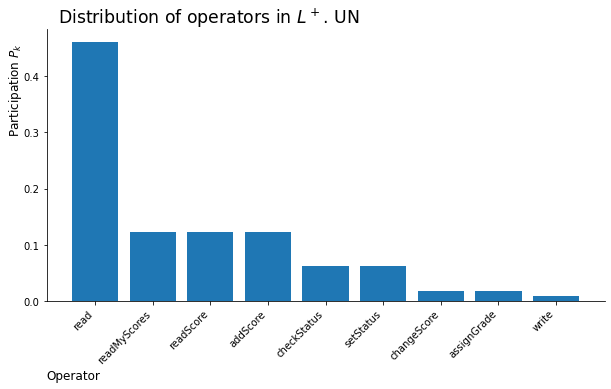

In [53]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
#access_distri = positive_ar.uname.value_counts(normalize=True)
access_distri = universal_access_log[universal_access_log.ACTION==1].op.value_counts(normalize=True)
ax.bar(access_distri.index, access_distri.values)
plt.xticks(rotation=45, ha="right")
ax.set_xlabel('Operator', loc="left", size="large")
ax.set_ylabel('Participation $P_k$', loc="top", size="large")
ax.yaxis.set_label_coords(-0.04,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of operators in $L^+$. UN", size="xx-large", x=0.29, y=1)
plt.savefig("HC-UserDistri.svg")
plt.show()

c:\Users\danie\anaconda3\envs\tesis_env\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (1,3,4,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


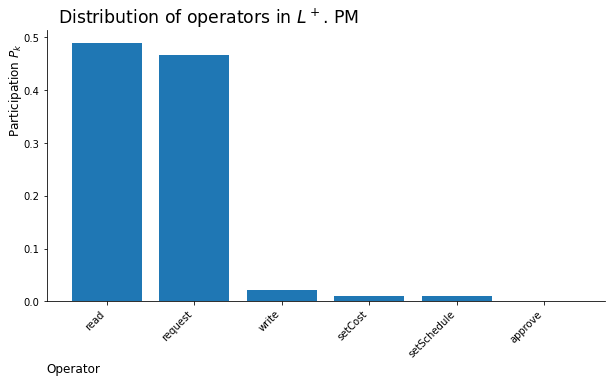

In [57]:
universal_access_log = pd.read_csv("../data/PM-universal.csv")

fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
#access_distri = positive_ar.uname.value_counts(normalize=True)
access_distri = universal_access_log[universal_access_log.ACTION==1].op.value_counts(normalize=True)
ax.bar(access_distri.index, access_distri.values)
plt.xticks(rotation=45, ha="right")
ax.set_xlabel('Operator', loc="left", size="large")
ax.set_ylabel('Participation $P_k$', loc="top", size="large")
ax.yaxis.set_label_coords(-0.04,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of operators in $L^+$. PM", size="xx-large", x=0.29, y=1)
plt.savefig("HC-UserDistri.svg")
plt.show()

In [58]:
universal_access_log = pd.read_csv("../data/IoT/0-IoT-universal.csv")

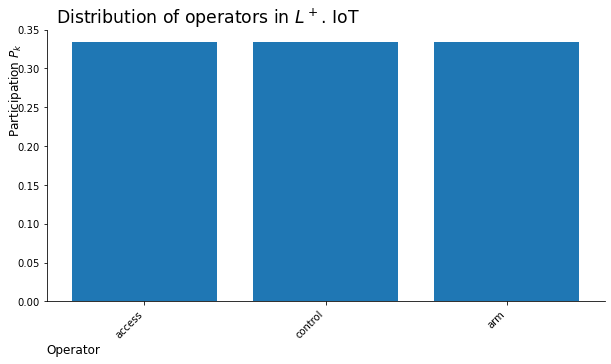

In [60]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
#access_distri = positive_ar.uname.value_counts(normalize=True)
access_distri = universal_access_log[universal_access_log.ACTION==1].op.value_counts(normalize=True)
ax.bar(access_distri.index, access_distri.values)
plt.xticks(rotation=45, ha="right")
ax.set_xlabel('Operator', loc="left", size="large")
ax.set_ylabel('Participation $P_k$', loc="top", size="large")
ax.yaxis.set_label_coords(-0.04,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of operators in $L^+$. IoT", size="xx-large", x=0.29, y=1)
plt.savefig("HC-UserDistri.svg")
plt.show()

In [62]:
len(universal_access_log), len(universal_access_log[universal_access_log.ACTION==1]), len(universal_access_log[universal_access_log.ACTION==0])

(5702400, 4276800, 1425600)